## Building up tVMC

Next step - Overlap optimization for the NN - but first verify ground state optimization

In [313]:
%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [314]:
import jax
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import jax.numpy as jnp
from sampling import metropolis_step
from local_energy import get_local_energy_fn

In [315]:
key = jax.random.key(seed=3)
batch_size = 4200
pos = jax.random.normal(key, (batch_size, 3))

### Hydrogen superposition - relative phase beating mode

In [316]:


def f(params, x):
    """
    Wavefunction representing the superposition of the ground and first excited state of Hydrogen.
    params: theta (relative phase between 1s and 2s)
    """
    theta_1 = params.at[0].get()
    theta_2 = params.at[1].get()
    
    r = jnp.linalg.norm(x)
    
    # 1s wavefunction (ground state)
    psi_1s = (
        1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r) * jnp.exp(
            -1j * theta_1)
    
    # 2s wavefunction (first excited state)
    psi_2s =(
        1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(
            -r / 2) * jnp.exp(-1j * theta_2) 
    
    # Superposition with two phases
    return (psi_1s + psi_2s) / jnp.sqrt(2)

batched_f = jax.jit(jax.vmap(f, in_axes=(None, 0)))

In [317]:
params = jax.random.uniform(key, (2,))
te = get_local_energy_fn(f, 1, 1)

In [318]:
def get_energy_mean_variance(energies):
    me = jnp.mean(energies)
    var = jnp.mean((energies - me) ** 2)
    return me, var

In [319]:
mc_step = metropolis_step(params, batched_f, pos, key)

In [320]:
# Warmup steps
key, subkey = jax.random.split(key)
pos = jax.random.uniform(subkey, (4200, 3))

for i in range(200):
    key, subkey = jax.random.split(key)
    pos, pmove = mc_step(params, pos, subkey, mcmc_width=0.5)
print(pmove)

0.67811906


In [321]:
energies = te(params, pos)

In [322]:
get_energy_mean_variance(energies)

(Array(-0.32415932-0.00061442j, dtype=complex64),
 Array(0.03121034+0.00091649j, dtype=complex64))

In [323]:
def get_update(params, pos, diagonal_shift=1e-7):
    """Gets theta dot"""
    def invert_qgt(s):
        # Handle both scalar and matrix cases
    
        # Matrix case - use pseudoinverse
        U, eigs, Vt = jnp.linalg.svd(s, full_matrices=False)
        threshold = 1e-5
        eigs_inv = jnp.where(eigs > threshold, 1/eigs, 0.0)
        s_pinv = (Vt.conj().T * eigs_inv) @ U.conj().T
        return s_pinv

    o_alpha = jax.jacfwd(lambda p: jnp.log(batched_f(p, pos)))(params)
    
    # Vector parameter case
    batch_size = o_alpha.shape[0]
    o_alpha_centered = o_alpha - jnp.mean(o_alpha, axis=0, keepdims=True)
    s = jnp.real(jnp.dot(jnp.conj(o_alpha_centered).T, o_alpha_centered) / batch_size)
    s = s + jnp.eye(o_alpha.shape[1]) * diagonal_shift
    s_inv = invert_qgt(s)
   
    # Local energy
    energy = te(params, pos)  # shape: (n_samples,)
    

    # Vector parameters
    F = (jnp.dot(jnp.conj(o_alpha).T, energy) / batch_size 
         - jnp.mean(jnp.conj(o_alpha), axis=0) * jnp.mean(energy))
    theta_dot = jnp.dot(s_inv, jnp.imag(F))

    return theta_dot

In [324]:
get_update(params, pos)

Array([-0.1874994 ,  0.18749942], dtype=float32)

In [325]:
energy = te(params, pos)

In [327]:
dt = 0.01

In [328]:

r_expect = []
for i in tqdm(range(6000)):
    #key, subkey = jax.random.split(key)
    #pos = jax.random.uniform(subkey, (200, 3))

    #for j in range(30):
    #    key, subkey = jax.random.split(key)
    #    pos, pmove = mc_step(params, pos, subkey, 0.5)
        
    theta_dot = get_update(params, pos)
    #print(jnp.abs(params[0] - params[1]))
    #print(theta_dot)

    params = params + dt * theta_dot
    density = jnp.abs(batched_f(params, pos)) ** 2

    r = jnp.linalg.norm(pos, axis=1)
    r_exp = jnp.mean(r)
    
    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)
    Eloc = te(params, pos)
    #r_expect.append(r_exp)
    #print(r_exp)
    if i % 1000 == 0:
        print(f"Elocal {jnp.mean(Eloc)}")
        print(f"Evar {jnp.mean((Eloc - jnp.mean(Eloc)) ** 2)}")

  0%|          | 0/6000 [00:00<?, ?it/s]

Elocal (-0.3241688907146454-0.0006526504294015467j)
Evar (0.031181443482637405+0.0009708193247206509j)
Elocal (-0.4330599009990692+0.05515151098370552j)
Evar (0.035404566675424576-0.02104705199599266j)
Elocal (-0.351420134305954-0.03413191810250282j)
Evar (0.021019183099269867+0.013043772429227829j)
Elocal (-0.3500243127346039+0.032887570559978485j)
Evar (0.02105282060801983-0.012756711803376675j)
Elocal (-0.4361509084701538-0.05400605499744415j)
Evar (0.03645707294344902+0.02083306759595871j)
Elocal (-0.32410264015197754+0.0003181678184773773j)
Evar (0.031385716050863266-0.0004825947980862111j)


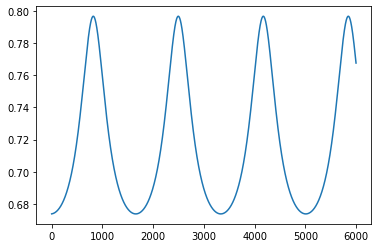

In [329]:
plt.plot(r_expect)

Getting peak frequency
Extracted ω: 0.41887902047863906


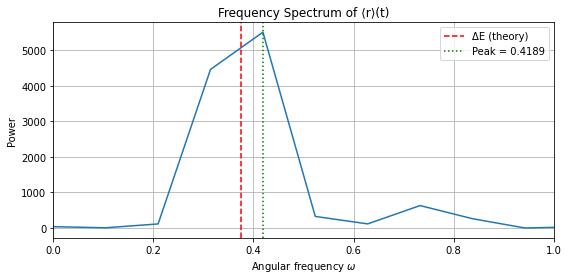

In [330]:

import numpy as np

print("Getting peak frequency")
r_expect = jnp.array(r_expect)
signal = r_expect - jnp.mean(r_expect)

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exactly solved version

### Radial Grid

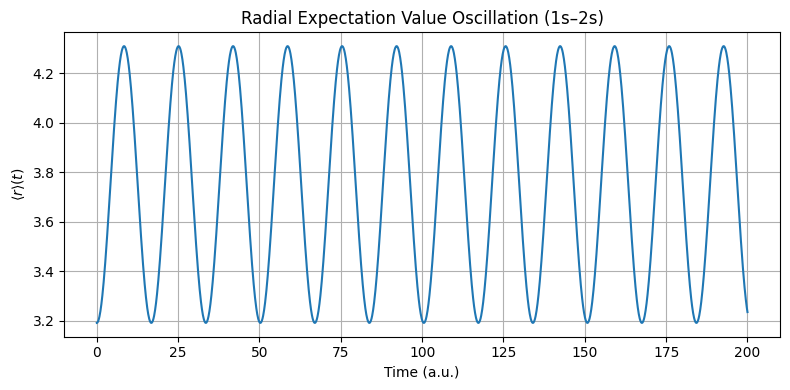

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------
# Energies (atomic units)
# -------------------------
E1 = -0.5
E2 = -0.125
omega = E2 - E1

# -------------------------
# Radial grid
# -------------------------
r = np.linspace(0, 40, 4000)
dr = r[1] - r[0]

# -------------------------
# Hydrogen wavefunctions
# -------------------------
psi_1s = (1 / np.sqrt(np.pi)) * np.exp(-r)
psi_2s = (1 / (4 * np.sqrt(2 * np.pi))) * (2 - r) * np.exp(-r / 2)

# -------------------------
# Time-dependent wavefunction
# -------------------------
def psi_t(t):
    return (psi_1s * np.exp(-1j * E1 * t)
          + psi_2s * np.exp(-1j * E2 * t)) / np.sqrt(2)

# -------------------------
# Time grid
# -------------------------
t = np.linspace(0, 200, 2000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_t(ti)
    density = np.abs(psi)**2
    r_exp = np.sum(density * r * 4*np.pi*r**2) * dr
    r_expect.append(r_exp)

r_expect = np.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()


### Metropolis sampling and autodiff energy gradients

In [22]:
from local_energy import get_local_energy_fn

In [21]:
def f(params, x):
    r = jnp.linalg.norm(x)
    psi = (
        (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
        + (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)
    ) / jnp.sqrt(2)
    return psi

In [23]:
f_b = jax.vmap(f, in_axes=(None, 0))

loc_energy = get_local_energy_fn(f, 1, 1)

In [24]:
le = loc_energy(params, pos)

In [25]:
jnp.mean(loc_energy(params, pos))

Array(-0.40925688+0.j, dtype=complex64)

In [26]:
## Warmup steps
pos = jax.random.uniform(key, (4200, 3))

for i in range(10):
    pos, pmove = metropolis_step(params, f_b, pos, key, 0.5)
print(pmove)

0.576619


In [60]:
le = loc_energy(params, pos)

In [61]:
jnp.mean(le)

Array(-0.39638376+0.j, dtype=complex64)

In [63]:
jnp.mean(le - jnp.mean(le))

Array(1.2800807e-08+0.j, dtype=complex64)

In [64]:
jnp.mean((le - jnp.mean(le)) ** 2)

Array(0.04612977+0.j, dtype=complex64)

In [19]:
E1 = -0.5
E2 = -0.125

def psi_t(params, x, t):
    r = jnp.linalg.norm(x)

    psi_1s = (1 / jnp.sqrt(jnp.pi)) * jnp.exp(-r)
    psi_2s = (1 / (4 * jnp.sqrt(2 * jnp.pi))) * (2 - r) * jnp.exp(-r / 2)

    return (
        psi_1s
        + psi_2s * jnp.exp(-1j * (E2-E1) * t)
    ) / jnp.sqrt(2)

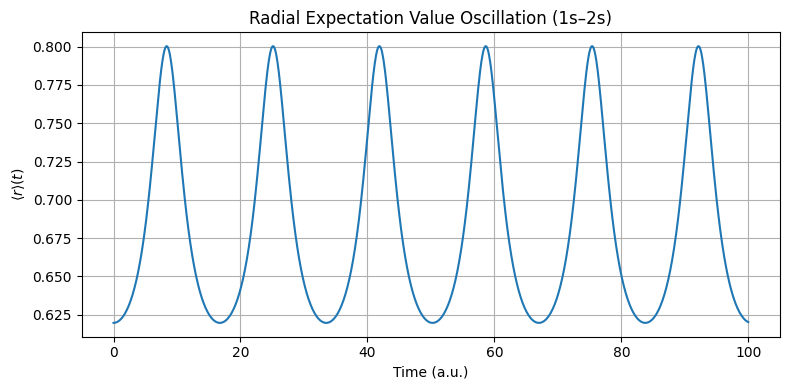

In [ ]:
#def psi_t(params, x, t):
#    return f(params, x) * jnp.exp(-1j * (E2 - E1) * t)

psi_b = jax.vmap(psi_t, in_axes=(None, 0, None))

# -------------------------
# Time grid
# -------------------------
t = jnp.linspace(0, 10.0, 1000)

# -------------------------
# Compute <r>(t)
# -------------------------
r_expect = []

for ti in t:
    psi = psi_b(params, pos, ti)
    density = jnp.abs(psi) ** 2
    r = jnp.linalg.norm(pos, axis=1)

    r_expect_t = jnp.sum(density * r) / jnp.sum(density)
    r_expect.append(r_expect_t)

r_expect = jnp.array(r_expect)

# -------------------------
# Plot
# -------------------------
plt.figure(figsize=(8, 4))
plt.plot(t, r_expect)
plt.xlabel("Time (a.u.)")
plt.ylabel(r"$\langle r \rangle(t)$")
plt.title("Radial Expectation Value Oscillation (1s–2s)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Frequency extraction

In [24]:
import numpy as np

signal = r_expect - jnp.mean(r_expect)
dt = t[1] - t[0]

fft_vals = np.fft.rfft(signal)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2

idx = np.argmax(power[1:]) + 1   # skip zero frequency
f_peak = freqs[idx]

omega_peak = 2 * np.pi * f_peak
print("Extracted ω:", omega_peak)


Extracted ω: 0.37661415


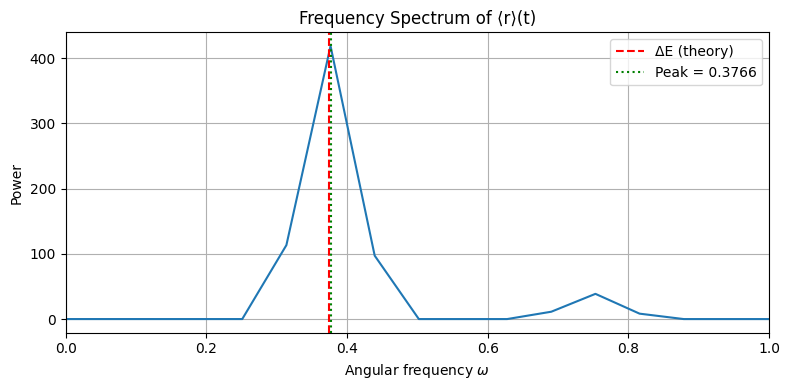

In [25]:
dt = t[1] - t[0]

signal = r_expect - np.mean(r_expect)
window = np.hanning(len(signal))

fft_vals = np.fft.rfft(signal * window)
freqs = np.fft.rfftfreq(len(signal), dt)

power = np.abs(fft_vals) ** 2
omega = 2 * np.pi * freqs

plt.figure(figsize=(8, 4))
plt.plot(omega, power)
plt.axvline(0.375, color="red", linestyle="--", label="ΔE (theory)")
plt.axvline(omega[np.argmax(power[1:]) + 1],
            color="green", linestyle=":",
            label=f"Peak = {omega[np.argmax(power[1:]) + 1]:.4f}")

plt.xlim(0, 1.0)
plt.xlabel(r"Angular frequency $\omega$")
plt.ylabel("Power")
plt.title("Frequency Spectrum of ⟨r⟩(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
